In [ ]:
# Approximating DGSM indices
# Authors: Zahra Aminzare, Kerry Tarrant
# Source(s): 
#   Dela, A., Shtylla, B., & Pillis, L.D. (2022). "Supplementary Information
#       Multi-method Global Sensitivity Analysis in Mathematical Models."

# Initialization

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
from scipy.stats import norm

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

import random
import time

# Latin Hypercube Sampling


In [ ]:
def LHS_Call(xmin,
             xmean,
             xmax,
             xsd,
             Nsample,
             distribution,
             threshold):
    
    if Nsample==1:
        s=xmean
        return s

    if np.isscalar(xmean):
        Nparams=1
        xmean=np.array([xmean])
        xsd=np.array([xsd])
    else:
        Nparams=len(xmean)

    if distribution=='norm':
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            s[:,j] = xmean[j] + norm.ppf[P]*xsd[j]        

    if distribution=='unif':
        if xmin==0:
            xmin=1e-300
        if np.isscalar(xmin):
            Nparams=1
            xmin=np.array([xmin])
            xmax=np.array([xmax])
        else:
            Nparams=len(xmin)
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            if (xmax[j]<1 and xmin[j]<1) or (xmax[j]>1 and xmin[j]>1):
                # Same range
                if (xmax[j]/xmin[j])<threshold:
                    #
                    s[:,j]=xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(abs(np.log(xmax[j])) - abs(np.log(xmin[j])))
                    s[:,j] = np.exp(s[:,j])
            else:
                if (xmax[j]/xmin[j])<threshold:
                    s[:,j] = xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(np.log(xmax[j]) - np.log(xmin[j]))
                    s[:,j] = np.exp(s[:,j])
    if np.shape(s)[1]==1:
        return s.flatten()
    else:
        return s

# Conditional matrices

In [ ]:
def conditional_matrices(mat_A,mat_B):
    Nparams=len(A[0,:])
    # C_i: same as matrix A but replace the ith column of A with the ith column of B
    C = []
    for index in range(Nparams):
        C_i = mat_A.copy()
        C_i[:,index] = mat_B[:,index].copy()
        C.append(C_i.copy())

    # D_i: same as matrix B but replace the ith column of B with the ith column of A
    D = []
    for index in range(Nparams):
        D_i = mat_B.copy()
        D_i[:,index] = mat_A[:,index].copy()
        D.append(D_i.copy())
    return C, D

# Parameters from a uniform distribution

In [ ]:
def repeat_rand(array,
                integer):
    
    rng = np.random.default_rng()
    array = np.repeat(array,integer)
    rng.shuffle(array)
    array = array.reshape(-1,1)

    return array

# Sobol' Method Algorithm

In [ ]:
## Variance of the conditional expectation VCE
def var_Y(Y_A,
          Y_B):
    N = len(Y_A)
    mu_Y_A = np.mean(Y_A)
    mu_Y_B = np.mean(Y_B)
    var = (1/(2*N))*np.sum(
        (Y_A - mu_Y_A)**2 + (Y_B - mu_Y_B)**2
        )
    return var

# Total variance
def var_total(Y_A,
              Y_B):
    Y = np.vstack((np.reshape(Y_A, (-1,1)), np.reshape(Y_B, (-1,1))))
    N = len(Y[:,0])
    mu_Y = np.mean(Y)
    var = (1/N)*np.sum((Y-mu_Y)**2)
    return var

## Variance of expectation of output given fixed parameter
def var_e_Y_given_Xi(Y_A,
                     Y_B,
                     Y_C):
    N = len(Y_A)
    var = (1/N)*np.sum(Y_B*np.abs(Y_C-Y_A)) # abs from Sobol_HIV_main.m
    return var

## Expectation of variance of output given all other parameters
def e_var_Y_given_notXi(Y_A,
                        Y_C):
    N = len(Y_A)
    var = (1/(2*N))*np.sum((Y_A-Y_C)**2)
    return var

# ODE System, Solver

In [ ]:
# Runs ODE with given parameters and returns steady state of volume.
def CollectSample(params):
    
    # System of ODE
    def RHS_OHM(t,X):

        ## State variables
        naA = X[0]
        kA  = X[1]
        clA = X[2]
        wA  = X[3]

        ## Parameters
        pnka  = params.pnka
        pnkcc = params.pnkcc
        pkcc  = params.pkcc
        pncc  = params.pncc

        na_e  = params.na_e
        k_e   = params.k_e
        cl_e  = params.cl_e
        gna   = params.gna
        gk    = params.gk
        gcl   = params.gcl
        R     = params.R
        F     = params.F
        C     = params.C
        kp    = params.kp
        kna   = params.kna
        nu1   = params.nu1
        xA    = params.xA 
        zA    = params.zA
        y_e   = params.y_e


        ## Sodium pump & cotransporters

        # Constant 
        pNA = -3*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        pK  = 2*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        
        # Nonlinear 
        # pNA = -pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        # pK  = (2/3)*pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        # pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        

        ## Nernst  
        EnaA = (R)*np.log(na_e/naA)
        EkA  = (R)*np.log(k_e/kA)
        EclA = -(R)*np.log(cl_e/clA)

        ## Voltage
        VA=((F*wA)/C)*(naA+kA-clA+zA*(xA/wA))

        ## Volumes
        OsA=naA+kA+clA+xA/wA
        Oso=na_e+k_e+cl_e+y_e

        dwA= nu1*(OsA-Oso)

        ## Ions
        dnaA = (-gna*(VA-EnaA)+pNA)/(F*wA) - dwA*naA/wA
        dkA  = (-gk*(VA-EkA)+pK)/(F*wA) - dwA*kA/wA
        dclA = (gcl*(VA-EclA)+pCl)/(F*wA) - dwA*clA/wA

        ## All
        dX   = [dnaA, dkA, dclA, dwA]

        return dX

    ## Simulation time in seconds
    t0   = 0*3600
    tmax = 5*3600

    ## Initial conditions
    wA0  = params.wA0
    a    = 0.2
    clA0 = (Oso/2) - (xA/wA0)
    naA0 = a*Oso/2
    kA0  = (1-a)*Oso/2

    X_0   = [naA0, kA0, clA0, wA0]

    ## Solver
    results = solve_ivp(RHS_OHM,
                        (t0, tmax),
                        X_0,
                        method='LSODA',
                        rtol=1e-7
                        )
    
    ## Approximation of steady state of volume
    w_ss = results.y[-1,-1]

    # ## Take the last volume that is not NaN and positive
    # if np.isnan(w_ss):
    #     w_ss = results.y[-1,~np.isnan(results.y[-1,:])]
    #     mask = w_ss>0
    #     w_ss = w_ss[mask]
    #     w_ss = w_ss[-1]

    ## Exclude NaN
    if ~np.isnan(w_ss):
        NaN_mask = True
    else:
        NaN_mask = False

    return 100*w_ss/wA0, NaN_mask

# Intial Conditions, Parameters

In [ ]:
## Fixed external concentraions and charges
Oso  = 300e-3
y_e  = 10e-3
z_e  = -1
k_e  = 3e-3
cl_e = 0.5*(Oso-y_e+(z_e*y_e))
na_e = -k_e+cl_e-(z_e*y_e)

## Area
radA = 5
radA = radA*1e-5

## Surface area and volumes
Ar1 = 4*np.pi*radA**2
wA0 = (4/3)*np.pi*radA**3

## Pump and cotransporters parameters
pnka  = 1*Ar1
pnkcc = 10*Ar1
pkcc  = 1*Ar1
pncc  = 1*Ar1

kp   = 0.883*1e-3
kna  = 3.56*1e-3

## Conductances
gna = 0.01*0.1*Ar1
gk  = 0.3*0.1*Ar1
gcl = 0.02*0.1*Ar1

## Other constants
R = 26.73*1e-3
F = 96485
C = 1e-3*Ar1

## Unknown impermeable molecule concentration and charge
xA = wA0*50e-3
zA = -1

## Permeability parameter
nu1 = 7*18*1e-4*Ar1

class params:
        pnka  = pnka
        pnkcc = pnkcc
        pkcc  = pkcc
        pncc  = pncc
        na_e  = na_e
        k_e   = k_e
        cl_e  = cl_e
        gna   = gna
        gk    = gk
        gcl   = gcl
        R     = R
        F     = F
        C     = C
        kp    = kp
        kna   = kna
        nu1   = nu1
        xA    = xA
        zA    = zA
        y_e   = y_e
        wA0   = wA0

# Notes

The arrays **pnka_array**, **pnkcc_array**, **pkncc_array**, and **pncc_array** are of length defined by the variable **samples_in_each_range_size**. The values in these arrays are linearly spaced between 0 and some maximum paramter value.

The variable **samples_in_each_range_size** can be thought of as the resolution of **group_1**. If there are $n$ cotransporters in the search, then there will be **samples_in_each_range_size**$^{n+1}$ parameter points.

The each row of array **group_1** is a parameter point and each column of **group_1** is a value associated with a particular parameter. As an example, **group_1** has the following form:

| Parameter point | $p_{NKA}$ | $p_{NKCC}$ | $p_{KCC}$ | $p_{NCC}$ |
|-:|-:|-:|-:|-:|
| Parameter point 1 | 0 | 0 | 0 | 0 |
| Parameter point 2 | 0 | 0 | 0 | 0.00025 |
| . . . | | | | |

The array **group_2** is the same shape as **group_1** with unifromly distributed parameter points between the same values defined in each parameter array.

# Pump and Three Cotransporters

## $p_{NKA}$, $p_{NKCC}$, $p_{KCC}$, and $p_{NCC}$

A dummy parameter is also included.

### Collect samples

In [ ]:
# Number of samples
Nsamples = 10000

# Minimum, maximum, and baseline parameter values.
pnka_min = 0
pnkcc_min = 0
pkcc_min = 0
pncc_min = 0
dummy_min = 1
p_min = np.array([pnka_min,
                  pnkcc_min,
                  pkcc_min,
                  pncc_min,
                  dummy_min])
pnka_max = 1.5*pnka
pnkcc_max = 2.5*pnkcc
pkcc_max = 0.25*pkcc
pncc_max = 0.015*pncc
dummy_max = 10
p_max = np.array([pnka_max,
                  pnkcc_max,
                  pkcc_max,
                  pncc_max,
                  dummy_max])
dummy = 1
baseline = np.array([pnka,
                     pnkcc,
                     pkcc,
                     pncc,
                     dummy])

# Number of parameters
Nparams = len(p_min)

# Initial sample A
threshold = 1e+300
A = np.zeros((Nsamples,Nparams))
for index in range(Nparams):
    A[:,index] = LHS_Call(p_min[index],
                          baseline[index],
                          p_max[index],
                          0,
                          Nsamples,
                          'unif',
                          threshold)

# Simulate baseline model output for each row of LHS matrix.
Y_A = np.zeros((Nsamples,1))
for index in range(Nsamples):
    parameter_point = A[index].copy()
    params.pnka = parameter_point[0]
    params.pnkcc = parameter_point[1]
    params.pkcc = parameter_point[2]
    params.pncc = parameter_point[3]
    Y_A[index] = CollectSample(params)

# Perturb each parameter by some \delta x_i while others are fixed.
# (Implemented in next for loop.)
dp_vec = np.diff(A.copy(), axis=0)
dp_vec = abs(dp_vec.min(axis=0)).copy()
dp = np.diagflat(dp_vec).copy()

# For each row j of LHS matrix make k copies.
A_dp = []
for row in range(Nsamples):
    A_dp_i = np.zeros((Nparams,Nparams))
    for copies in range(Nparams):
        A_dp_i[copies,:] = A[row,:].copy()
    A_dp_i = A_dp_i.copy() + dp.copy()
    A_dp.append(A_dp_i.copy())

# Simulate baseline model output for each modified jth row of LHS.
Y_dp = []
for matrix in A_dp:
    A_dp_i = matrix.copy()
    Y_dp_i = np.zeros((Nparams,1))
    for index in range(Nparams):
        parameter_point = A_dp_i[index].copy()
        params.pnka  = parameter_point[0]
        params.pnkcc = parameter_point[1]
        params.pkcc  = parameter_point[2]
        params.pncc  = parameter_point[3]
        Y_dp_i[index] = CollectSample(params)
    Y_dp.append(Y_dp_i.copy())

# Compute derivative matrix.
dY = np.zeros((Nsamples,Nparams))
for row in range(Nsamples):
    dY[row,:] = (Y_dp[row] - Y_A[row]).flatten() / dp_vec.flatten()

# Compute relative derivative matrix.
S = np.zeros_like(dY)
for row in range(Nsamples):
    for column in range(Nparams):
        S[row,column] = dY[row,column] * A[row,column] / Y_A[row]

### DGSM ratio and Gi for each parameter

In [ ]:
# Taking avergae and standard deviation of each column of 
# the relative derivative matrix.
mu = np.zeros(Nparams)
sd = np.zeros(Nparams)
Gi = np.zeros(Nparams)
ratio = np.zeros(Nparams)
for column in range(Nparams):
    mu[column] = np.mean(abs(S[:,column]))
    sd[column] = np.std(abs(S[:,column]))
    Gi[column] = (mu[column]**2 + sd[column]**2)**0.5
    ratio[column] = mu[column] / sd[column]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
parameter_labels = ['$p_{NKA}$ ', '$p_{NKCC}$', '$p_{KCC}$ ', '$p_{NCC}$ ', '$dummy$   ']

print('Parameter  | Ratio               | G_i                   ',
      '\n______________________________________________________________')
for parameter in range(Nparams):
    print(parameter_labels[parameter], '|', ratio[parameter], '|', Gi[parameter])

Parameter  | Ratio               | G_i                    
______________________________________________________________
$p_{NKA}$  | 0.24048520359402786 | 0.013171005714765684
$p_{NKCC}$ | 0.3524708036151446 | 1.8756956605266597
$p_{KCC}$  | 1.903040547737319 | 0.03708152284283909
$p_{NCC}$  | 0.31855739321269455 | 1.5670658246603442
$dummy$    | nan | 0.0


### Plot of ratio and $G_i$

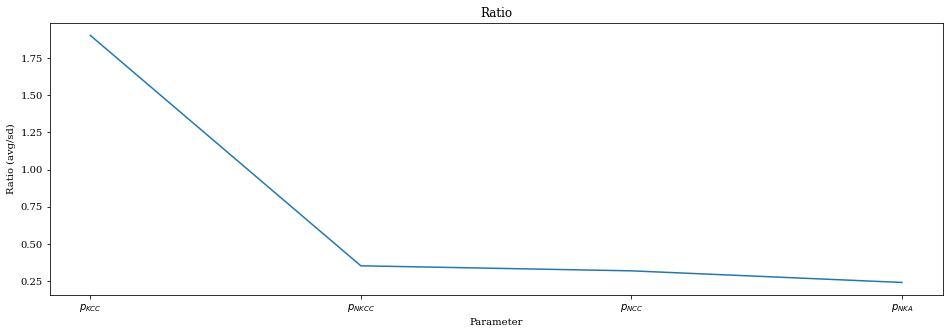

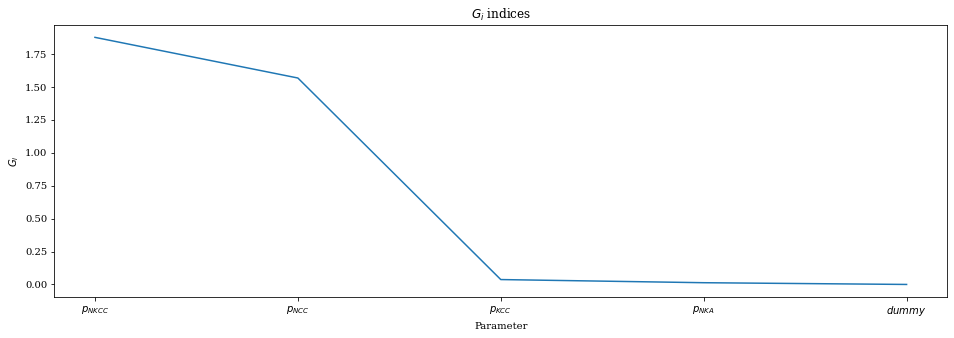

In [ ]:
parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$', '$dummy$']

# Plot ratio
plt.figure(figsize=(16,5))
mask = np.flip(np.argsort(ratio))
x_ax =[]
y_ax = []
for parameter in mask:
    x_ax.append(parameter_labels[parameter])
    y_ax.append(ratio[parameter])
plt.plot(x_ax, y_ax)
plt.xlabel('Parameter')
plt.ylabel('Ratio (avg/sd)')
plt.title('Ratio')
plt.show()

# Plot Gi
plt.figure(figsize=(16,5))
mask = np.flip(np.argsort(Gi))
x_ax =[]
y_ax = []
for parameter in mask:
    x_ax.append(parameter_labels[parameter])
    y_ax.append(Gi[parameter])
plt.plot(x_ax, y_ax)
plt.xlabel('Parameter')
plt.ylabel('$G_i$')
plt.title('$G_i$ indices')
plt.show()

### 2D plots: parameter vs volume ss

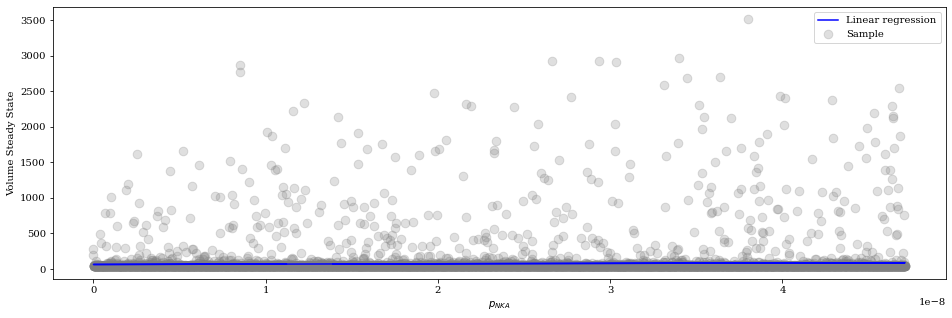

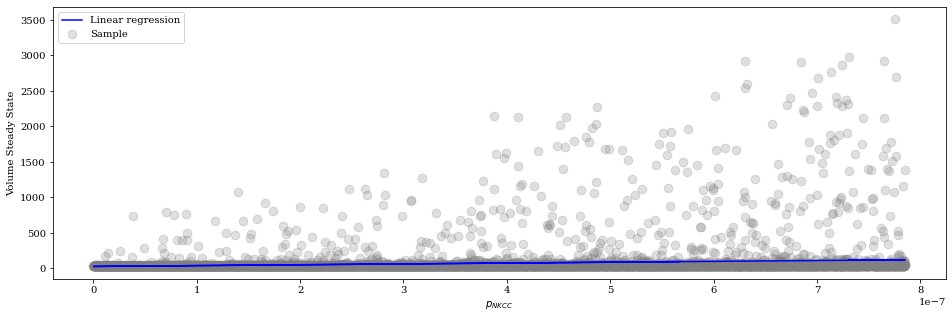

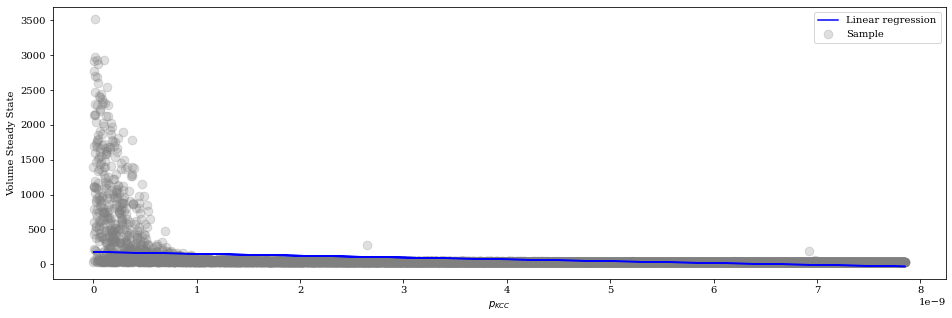

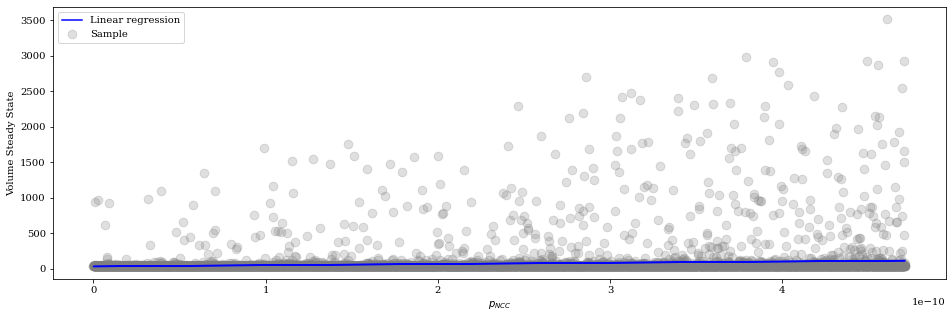

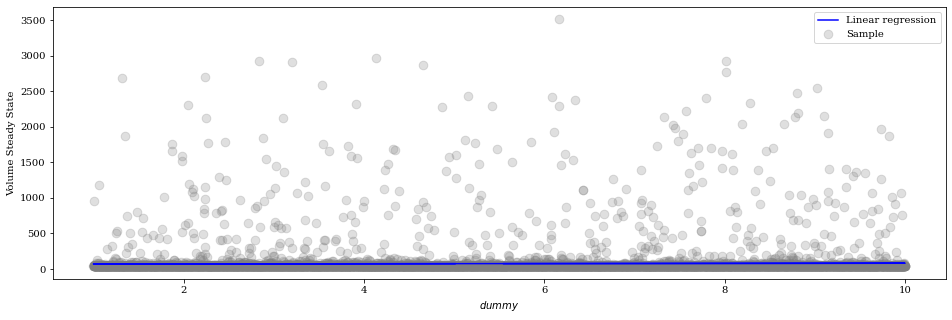

In [ ]:
## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$', '$dummy$']

x_ax = A
y_ax = Y_A

for parameter in range(len(parameter_labels)):
    plt.figure(figsize=(16,5))
    
    # Linear regression
    X = np.hstack((
        np.reshape(x_ax[:,parameter], (-1,1)),np.reshape(np.ones_like(x_ax[:,parameter]), (-1,1))
        ))
    coef = np.linalg.inv(X.T @ X) @ X.T @ y_ax

    plt.plot(x_ax[:,parameter], X @ coef, label='Linear regression', color='blue')

    # Samples
    plt.scatter(x_ax[:,parameter], y_ax, s=75, label='Sample', color='gray', alpha=0.25)

    plt.xlabel(parameter_labels[parameter])
    plt.ylabel('Volume Steady State')
    plt.legend(loc='best')
    plt.show()